This lab continues the series of labs to some of the most popular quantum algorithms. In
this lab, we will cover the Deutsch-Jozsa Algorithm, which are problems very closely related to the
Deutsch Algorithm. Both algorithms use a Hadamard Transformation as the core to their success, and are in fact solved with the
same circuit.

In order to make sure that all cells of code run properly throughout this lesson, please run the following cell of code below:

In [9]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute 

import math as m 

S_simulator = Aer.backends(name='statevector_simulator')[0]

M_simulator = Aer.backends(name='qasm_simulator')[0]

In [2]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [10]:
'''
Do not worry about the length of this code block.
You dont need to understand this code.
It is only to help you view the wavefunction in a better way
'''
import numpy as np


def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(statevec),2))
  for i in np.arange( int(len(statevec)) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)





# **The Deutsch-Jozsa Algorithm**
***

In the first part to this tutorial, we will be studying the Deutsch-Jozsa Algorithm, which is very closely related to the Deutsch
Algorithm. The difference in this new problem is that instead of a function f which maps a single bit of 0 or 1 as either a constant
or balanced function, we now have an f which maps an entire string of bits to either 0 or 1. More specifically, let’s say we have
a string of bits labeled $x_0 , x_1 , ... , x_n $, where each $x_i$ is either a 0 or a 1. When we pass our string of bits through the function
f , it returns a single value of 0 or 1:

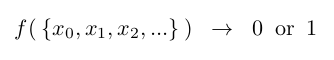

For a sting of n bits, there are a total of $2^n$ possible combinations. But, just like our previous problem, we are promised that f is
either a constant or balanced function. Here, a constant f returns all 0’s or 1’s for any input, while a balanced f returns 0’s and
1’s for exactly half of all inputs. For example:

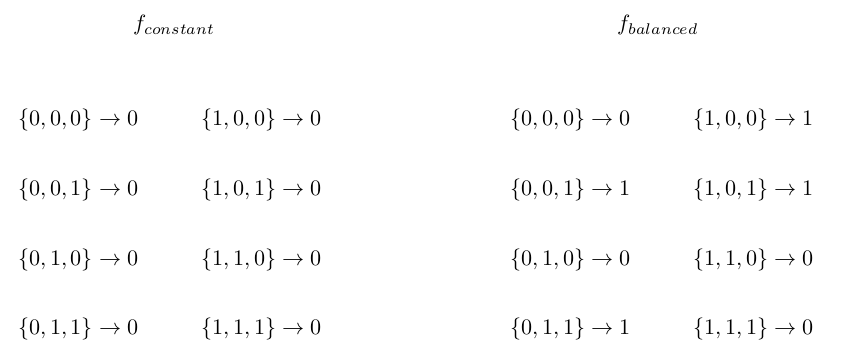

As shown above, our balanced function returns 0’s and 1’s for exactly half of the inputs (4 for the case of n = 3). And, the
ruleset governing which inputs return 0’s and 1’s is completely independent of the individual
bits. That is to say, if our f is truly a randomized balanced function, that takes n bit strings as input, then there are exponential possible
variations! Thus, there is no way to conclude any information about f by studying trends with individual bits. In fact, if we instead rewrite our strings of bits
as base 10 numbers, then our f function looks like the following:


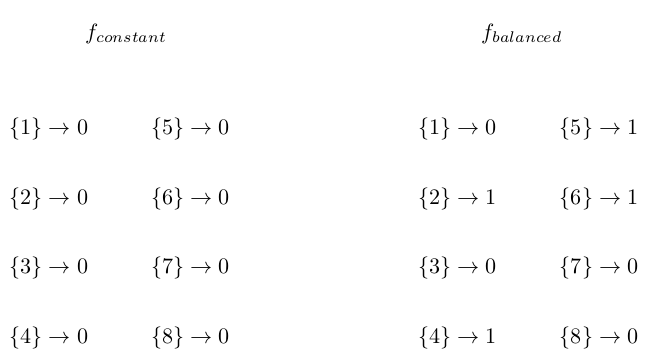

Written this way, it should be more clear that individual bits are meaningless to f . Only the string as a whole determines how
f operates on the input. Hopefully the setup for our new problem is clear, and how it varies from our previous lab. . Now then, the question we want to pose to both a classical and quantum computer is: ’how fast can you determine if f is
constant or balanced?’

## Classical



From the classical perspective, we must check each possible string of bits one by one until we can make a conclusion. In the
best case scenario, we get different outputs on our first two inputs, example: 0,0,0,.. → 0 and 1,0,0,... → 1. In fact, if we ever
get two different outputs, then we can 100% conclude our f is balanced. Conversely, if we continue to see the same output for
each input we try, for example:

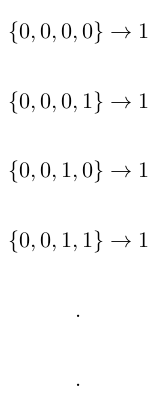

then we must check exactly $2^{n−1} + 1$ combinations in order to conclude that f is constant, which is one more than half the total. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in
succession, we can express the probability that our f is constant as a function of k inputs as:

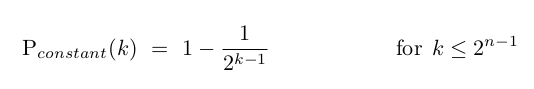

Perhaps more realistically, we can opt to truncate our classical algorithm early, say if we are over X% confident. But if we want
the full 100%, then we are stuck checking $2^{n−1} + 1$ entries.

## **Quantum**

For our quantum computer, we will solve this problem with 100% confidence after only one function call of f . As we shall see,
we achieve this result nearly the exact same way as the Deutsch Algorithm, with only a slight twist.

To show how similar the flow of this algorithm is to the previous one, let’s write the complete Deutsch and Deutsch-Jozsa
Algorithms side by side:

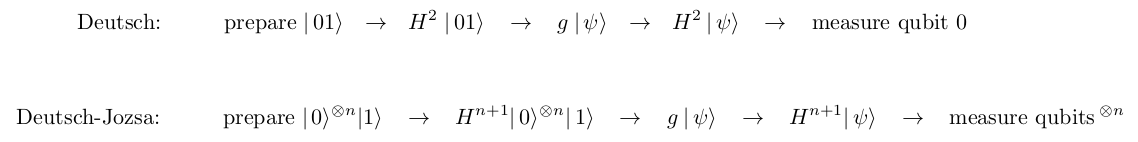

where once again g is the unitary function that contains our mystery function f .

Comparing these two algorithms, they’re nearly identical. The only difference here is that instead of using a single qubit in the
state |0⟩, we go through all of the steps with $|0⟩^{⊗n}$ . Recall that in the Deutsch Algorithm we used a single qubit paired with an
ancilla qubit to solve our problem (’ancilla’ refers to a qubit(s) that is used but doesn’t matter in the final measurement). Here,
for our new f that takes an n bit string, we use n qubits paired again with just a single ancilla.

Also like before, we will embed our function f into a unitary operator g, via addition modulo 2 ⊕. Let $X_i$ represent some string
$x_0 , x_1 , ...,$ then our g operator acts as follows:

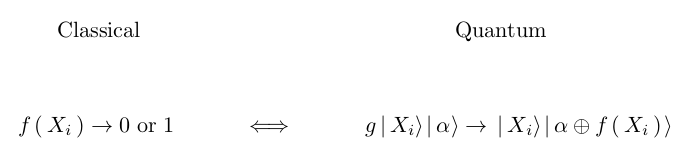

where the state $|X_i⟩$ refers to the state of the n individual qubits:

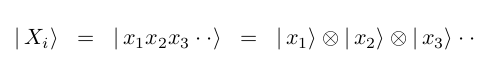

For example, suppose we had a particular f with the following:

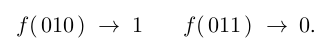

The corresponding g operator would then:

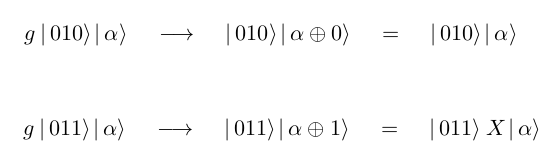

Note that we are using the fact that addition modulo 2 is equivalent to an X gate in this example, a result we showed in Intro to Quantum Algorithms lab ipynb. Thus, we can view the net effect of our g operator as picking out states at random and applying X gates to their ancilla
state. For the constant cases, we will have either all or none of the states in the system recieve X gates to their ancilla, while for
the balanced cases, exactly half of the states will receive the operation.

Just like the Deutsch Algorithm, a key component is the state |α⟩. As we’ve laid out our algorithm above, we initialize our
ancilla qubit in the |1⟩ state, and then apply a H to it, causing it to be in the state |− x⟩ before our g operator. This means that
the effect from the g operation will be as follows:

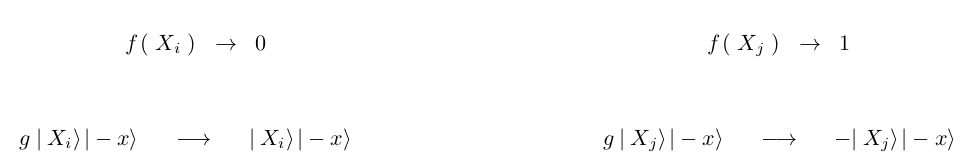

where this result comes from what happens when we apply an X gate to the state |− x⟩:

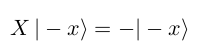

Proving this result is a nice exercise that I recommend doing at least once. Write out | − xi in the |0i, |1i basis, and it’s only
a couple line proof.

If you followed along with the Deutsch Algorithm, we used this exact trick. Here, we are using this technique again, only
on larger qubit states. Let’s see this effect in an example:

In [11]:
def n_NOT(qc, control, target, anc):
  '''
  performs an n-NOT gate
  '''
  n = len(control) 
  instructions = []
  active_ancilla = [] 
  q_unused = []
  q =0
  a = 0
  while( (n > 0) or (len(q_unused)!=0) or (len(active_ancilla)!=0)):
    if( n > 0):
      if( (n-2) >= 0):
        instructions.append( [control[q], control[q+1], anc[a]] ) 
        active_ancilla.append(a)
        a = a + 1
        n = n - 2 
      if( (n-2) == -1):
        q_unused.append(q) 
        n = n - 1
    elif(len(q_unused) != 0 ): 
      if(len(active_ancilla)!=1):
        instructions.append( [control[q], anc[active_ancilla[0]], anc[a]]) 
        del active_ancilla[0]
        del q_unused[0] 
        active_ancilla.append(a)
        a = a + 1
      else:
        instructions.append( [control[q], anc[active_ancilla[0]], target] )
        del active_ancilla[0] 
        del q_unused[0]
    elif(len(active_ancilla)!=0):
      if(len(active_ancilla) > 2 ): 
        instructions.append( [anc[active_ancilla[0]], anc[active_ancilla[1]], anc[a]] ) 
        active_ancilla.append(a)
        del active_ancilla[0] 
        del active_ancilla[0]
        a = a + 1
    elif(len(active_ancilla) == 2):
      instructions.append([anc[active_ancilla [0]], anc[active_ancilla[1]], target]) 
      del active_ancilla[0]
      del active_ancilla[0]
  for i in np.arange(len(instructions) ):
    qc.ccx( instructions[i][0], instructions[i][1], instructions[i][2] )
  del instructions[-1]
  for i in np.arange(len(instructions) ):
    qc.ccx( instructions [0-(i+1)][0], instructions [0-(i+1)][1], instructions[0-(i+1)][2] )

In [12]:
import numpy as np
import scipy as sci
def Blackbox_g_DJ (Q, qc, qreg, an1):
  '''
  Generates a random blackbox unitary operator g, based on a balanced or constant f
  '''
  f_type = ['constant', 'blanaced']

  f = [] 
  r = int( m.floor( 2**Q*sci.rand() ) )
  control = []

  for i in np.arange(Q):
    control.append( qreg[int(i)])

  if(r==0):
    for i in np.arange(Q): 
      qc.id( qreg[int(i)] )
    f.append(f_type[0]) 

  if(r==1):
    qc.x( qreg[int (Q-1)]) 
    f.append(f_type[0]) 

  if(r>=2):
    an2 = QuantumRegister(int(Q-2), name='nn_anc') 
    QC = QuantumCircuit(an2)
    qc += QC
    f.append(f_type[1]) 
    S = []

    for s in np.arange(2**Q):
       S.append(int(s) )

    for k in np.arange(2**(Q-1)):
      S_num = S[int(m.floor(len(S)*sci.rand()))] 
      state = Binary( S_num,2**Q,'L')
      S.remove(S_num) 
      f_string = '|'

      for j in np.arange(len(state)):
        f_string = f_string + str(int(state[j]))
        if(int(state[j])==0 ):
          qc.x( qreg[int(j)])
      n_NOT( qc, control, an1[0], an2) 
      for j in np.arange(len(state)):
        if(int(state[j])==0 ):
          qc.x( qreg[int(j)] )
      f.append(f_string+ '>')

  return f

In [13]:
q = QuantumRegister(3, name='q')

anc = QuantumRegister (1, name='anc')

DJ_qc = QuantumCircuit(q, anc, name='qc')

DJ_qc.h( q[0] )
DJ_qc.h( q[1])
DJ_qc.h( q[2] ) 
DJ_qc.x( anc[0])

##print('_ Before g ___', execute(DJ_qc,S_simulator).result().get_statevector() ) 
Wavefunction(DJ_qc)
DJ_qc.h( anc[0])

f = Blackbox_g_DJ( 3, DJ_qc, q, anc ) 
if( f[0]=='constant' ):
  A = 1

else:
  A = 2

DJ_qc.h(anc[0])

##print('\n After g___', execute(DJ_qc,S_simulator).result().get_statevector() ) 
Wavefunction(DJ_qc)

print('\nf type: ',f[0]) 
if(len(f)>1):
  print('states mapped to 1:',f[1:len(f)])

0.35355 |0001>     0.35355 |1001>     0.35355 |0101>     0.35355 |1101>     0.35355 |0011>     0.35355 |1011>     0.35355 |0111>     0.35355 |1111>     
0.35355 |0001>     0.35355 |1001>     0.35355 |0101>     0.35355 |1101>     0.35355 |0011>     0.35355 |1011>     0.35355 |0111>     0.35355 |1111>     

f type:  constant


/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_61797/684516748.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  qubits = int(m.log(len(statevec),2))
/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_61797/684516748.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i in np.arange( int(len(statevec)) ):
/var/folders/n5/sr7wwb8n1wg

The code above performs the Deutsch-Jozsa Algorithm up to the step where we apply our blackbox g. Run the cell of code a
couple times until you come across a case where f is balanced. When you do, you should notice that exactly half of the states
in the system pick up a negative sign. And, these states exactly match up with the states that get mapped to 1 by the embedded
f , printed at the bottom.

Next then, our algorithm calls for another Hadamard Transformation of our system, followed by a measurement:

In [14]:
q = QuantumRegister(3, name='q')
anc = QuantumRegister (1, name='anc')
c = ClassicalRegister(3,name='c')
DJ_qc = QuantumCircuit (q,anc, c, name='qc')

DJ_qc.h( q[0])
DJ_qc.h( q[1] )
DJ_qc.h( q[2]) 
DJ_qc.x( anc[0])

print('_ Before g __')
Wavefunction( DJ_qc, systems=[3,1], show_systems=[True, False] )

DJ_qc.h( anc[0])
f = Blackbox_g_DJ( 3, DJ_qc, q, anc) 
if( f[0] == 'constant' ):
  A = 1
else:
  A = 2

DJ_qc.h( anc[0])

print('\n After g f type: ',f[0], '___')

Wavefunction( DJ_qc, systems=[3,A], show_systems=[True, False] )

DJ_qc.h( q[0])
DJ_qc.h( q[1])
DJ_qc.h( q[2])

print("\n After H^3 ___")

Wavefunction( DJ_qc, systems=[3,A], show_systems=[True, False] )

DJ_qc.measure (q,c)



_ Before g __
0.35355 |000>     0.35355 |100>     0.35355 |010>     0.35355 |110>     0.35355 |001>     0.35355 |101>     0.35355 |011>     0.35355 |111>     

 After g f type:  constant ___
0.35355 |000>     0.35355 |100>     0.35355 |010>     0.35355 |110>     0.35355 |001>     0.35355 |101>     0.35355 |011>     0.35355 |111>     

 After H^3 ___
1.0 |000>     


/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_61797/684516748.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  qubits = int(m.log(len(statevec),2))
/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_61797/684516748.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i in np.arange( int(len(statevec)) ):
/var/folders/n5/sr7wwb8n1wg

Take a moment to carefully check each step in our ’DJ qc’ printed above, and you should find that all of our steps are in
agreement with the algorithm steps we outlined earlier:

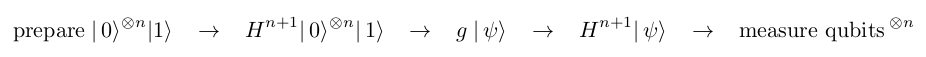

The only thing slightly out of order is that we apply the H gate to the ancilla qubit a little early. But, you can verify for yourself
that it is applied after g, so it is in agreement with the outlined steps.

Now for the final piece, what to do with our measured state. Recall that the solution to the Deutsch Algorithm problem was
based on whether we found qubit 0 in the state |0i or |1i:

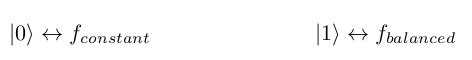

Here, we will make the same conclusion about f based on the measured state of our n qubits:

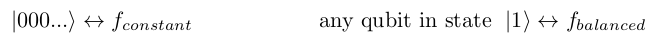

If we measure our n qubit system and we find that any of our qubits are in the |1⟩ state, we can conclude that f is balanced.

Conversely, if we find that all of the qubits are in the state |0⟩, we can conclude that f is constant. We can make both of these conclusions with 100% certainty. With this explanation now in hand, I encourage you to return to the cell of code above, and
confirm these results.

And that’s the full Deutsch-Jozsa Algorithm!